Viscoplastic thermal convection in a 2-D square box: Tosi et al. 2015
=====

This series of notebooks generates benchmark models from the Tosi et al. (2015) in Underworld2. The Underworld2 results are then directly compared to the results from Table 2 of Tosi et al. (2015) the paper for each case. The notebooks are broken into a general notebook for reproducing the models from scratch and 5 post-analysis notebooks which look at the results Underworld2 gives for each case after running to equilibrium. 

Parallel computer friendly version
-------

This general notebook contains the conditions for each of the cases in Tose et al. (2015) as well as being written in a way that is parallel computer friendly. This means that to run across multiple processors download this notebook as a python file and use this on your cluster of choice. Or use the supplied ``TosiParallel.py`` python script and run with a command like:

    mpirun -np 4 python TosiParallel.py 

To run case 5b modify the case 5a numbers to use $\sigma_\gamma$ = 3 to 5 with increment of 0.1.

References
-----

1. Tosi, Nicola and Stein, Claudia and Noack, Lena and H&uuml;ttig, Christian and Maierov&aacute;, Petra and Samuel, Henri and Davies, DR and Wilson, CR and Kramer, SC and Thieulot, Cedric and others. 2015. _A community benchmark for viscoplastic thermal convection in a 2-D square box_.


Load python functions needed for underworld. Some additional python functions from os, math and numpy used later on.

In [165]:
import underworld as uw
import math
from underworld import function as fn
import time
import numpy as np
import glucifer
import os

In [166]:
#!pip install natsort
#!pip install networkx

Set physical constants and parameters, including the Rayleigh number (*Ra*) and viscosity constants ($\eta^*$ and $\eta_T$) which are common to all Tosi et al cases.

In [167]:
ETA_T = 1e5

newvisc= math.exp(math.log(ETA_T)*0.53)

In [168]:
res = 128      # simulation resolution (horizontal and vertical directions)
RA  = 1e2*newvisc        # Rayleigh number
ETA_T = 1e5      # common viscosity constant
TS  = 0          # surface temperature
TB  = 1          # bottom boundary temperature (melting point)
ETA0 = 1e-3*newvisc      # viscosity constant eta^* in Tosi et al
TMAX = 3.0
IMAX = 1000
D = 2890.
ALPHA = 11.

In [169]:
LoadFromFile = False
RefineMesh = False


Select which case of Tosi et al (2015) to use. Must be between 1 and 5.

In [170]:
CASE = 4

Setup a dictonary containing viscosity and stress values for each case.

In [171]:
case_dict = {}
case_dict[1] = {}
case_dict[1]['ETA_Y'] = 1.
case_dict[1]['YSTRESS'] = 1.*newvisc
case_dict[2] = {}
case_dict[2]['ETA_Y'] = 1.
case_dict[2]['YSTRESS'] = 1.*newvisc
case_dict[3] = {}
case_dict[3]['ETA_Y'] = 10.
case_dict[4] = {}
case_dict[4]['ETA_Y'] = 10.
case_dict[4]['YSTRESS'] = 1.*newvisc
case_dict[5] = {}
case_dict[5]['ETA_Y'] = 10.
case_dict[5]['YSTRESS'] = 4.*newvisc

Set viscosity constants based on which Tosi et al case is being used.

In [172]:
ETA_Y = case_dict[CASE]['ETA_Y']
YSTRESS = case_dict[CASE]['YSTRESS']

Set input and output file directories

In [173]:
# input file directory
inputPath  = 'TosiInput/case' + str(CASE) + "/"

# output files
outputPath = 'TosiOutput/'
filePath   = outputPath+'files'

# make directories if they don't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
if not os.path.isdir(filePath):
    os.makedirs(filePath)

Create mesh and finite element variables
------

Set up mesh and field variables that are solved on the mesh. See user guides for details of this process.

In [174]:
minCoord    = (0., 0.) 
maxCoord    = (1., 1.035)

mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                 elementRes  = (res, res), 
                                 minCoord    = minCoord, 
                                 maxCoord    = maxCoord)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

#### mesh refine

In [175]:
ay = minCoord[1]
by = maxCoord[1]
ax = minCoord[0]
bx = maxCoord[0]

In [176]:
s = 1.2


newys = []
newxs = []
for index, coord in enumerate(mesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy =(by - (ay + (by-ay)*((by - y0)/(by-ay))**s))
    newx =(bx - (ax + (bx-ax)*((bx - x0)/(bx-ax))**s)) 
    newys.append(newy)
    newxs.append(newx)

In [177]:
maxCoord[1]

1.035

alpha=ALPHA
newys = []
newxs = []
for index, coord in enumerate(mesh.data):
    y0 = coord[1]
    x0 = abs(coord[0])
    newy = maxCoord[1]*(math.log(alpha*y0 + math.e) - 1)*(1/(math.log(alpha + math.e) - 1))
    newx = (math.log((alpha/2.)*x0 + math.e) - 1)*(1/(math.log((alpha/2.) + math.e) - 1))
    if coord[0] <= 0:
        newx = -1.*newx
    newys.append(newy)
    newxs.append(newx)
        

In [178]:
if RefineMesh:
    with mesh.deform_mesh():
        mesh.data[:,1] = newys
        mesh.data[:,0] = newxs


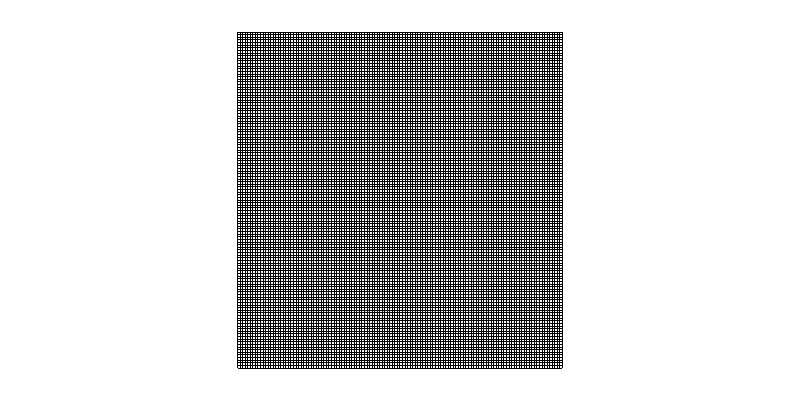

In [179]:

meshfig = glucifer.Figure(figsize=(800,400))
meshfig.append( glucifer.objects.Mesh(mesh) )
meshfig.show()
#meshfig.save_database('test.gldb')

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Either set by perturbation function or load data from file.

**If loading from file**

Read (``savedRes`` $\times$ ``savedRes``) resolution data for $P$, $v$ and $T$ fields as well as existing summary statistics data. These are converted into lists so that the main time loop below will append with new values.


In [180]:
if(LoadFromFile == False):
# Initialise data.. Note that we are also setting boundary conditions here
    velocityField.data[:]  = [0.,0.]
    pressureField.data[:]  = 0.
    temperatureDotField.data[:] = 0.
    temperatureField.data[:] = 0.
# Setup temperature initial condition via numpy arrays
    A = 0.01
#Note that width = height = 1
    for index, coord in enumerate(mesh.data):
        pertCoeff = (1- coord[1]) + A*math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
        temperatureField.data[index] = pertCoeff;    
    stepsVal = []
    timeVal = []
    viscdiscVal = []
    nu0Val = []
    nu1Val = []
    Avg_tempVal = []
    vrmsVal = []
    Rms_surfVal = []
    Max_vx_surfVal = []
    GravworkVal = []
    etamaxVal = []
    etaminVal = []


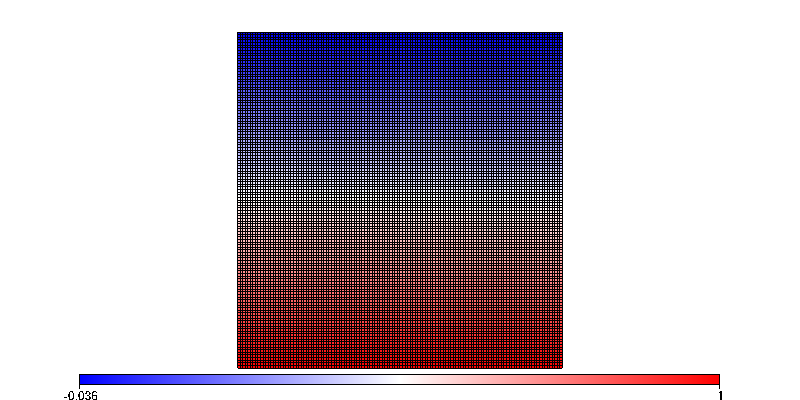

In [181]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.01))
figtemp.show()


In [182]:
def checkSurfaceIntegration(mesh, value, fn=1., rtol=1e-05):
    """
    This function performs surface integration across the entire boundary of the 
    provided mesh. The surface integration of 'fn' is expected to return a result 
    with 'rtol' of 'value'.
    
    Parameters
    ----------
        mesh : uw.mesh.FeMesh
            The mesh across which integration is to be performed.
        value: float
            The expected result of the integration.
        fn   : uw.function.Function
            The function which is to be integrated.
        rtol : float
            Relative tolerance. Check allclose documentation for details.
    """
    boundaryLength = uw.utils.Integral( fn=fn, mesh=mesh, integrationType='Surface', surfaceIndexSet=mesh.specialSets["AllWalls_VertexSet"])
    result = boundaryLength.evaluate()
    assert np.allclose( result, value, rtol=rtol ), "Error occurred in surface integration. Integration = {}, Expected = {}".format(result, value)
def checkVolumeIntegration(mesh, value, fn=1., rtol=1e-05):
    """
    This function performs volume integration across the entire volume of the 
    provided mesh. The volume integration of 'fn' is expected to return a result 
    with 'rtol' of 'value'.
    
    Parameters
    ----------
        mesh : uw.mesh.FeMesh
            The mesh across which integration is to be performed.
        value: float
            The expected result of the integration.
        fn   : uw.function.Function
            The function which is to be integrated.
        rtol : float
            Relative tolerance. Check allclose documentation for details.
    """

    totalVolume = uw.utils.Integral( fn=fn, mesh=mesh, integrationType='Volume')
    result = totalVolume.evaluate()
    assert np.allclose( result, value, rtol=rtol ), "Error occurred in volume integration. Integration = {}, Expected = {}".format(result, value)

In [183]:
def correctLength(minCoord,maxCoord):
    """ Calculates the total boundary length of a mesh created using minCoord,maxCoord. """
    return 2.*np.sum( maxCoord[ii] - minCoord[ii] for ii in range(0,len(minCoord)))
def correctVol(minCoord,maxCoord):
    """ Calculates the volume of a mesh created using minCoord,maxCoord. """
    return np.prod( [ maxCoord[ii] - minCoord[ii] for ii in range(0,len(minCoord)) ] ) 

In [184]:

#checkVolumeIntegration( mesh, correctVol(minCoord,maxCoord))

#checkSurfaceIntegration(mesh, correctLength(minCoord,maxCoord))

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [185]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = TB
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = TS

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [186]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

## Particles

In [187]:
# initialise a swarm
gSwarm = uw.swarm.Swarm( mesh=mesh )

# add a data variable which will store information on the particle
materialVariable   = gSwarm.add_variable( dataType="int", count=1 )


# create a layout object that will populate the swarm across the whole domain
swarmLayout = uw.swarm.layouts.PerCellRandomLayout( swarm=gSwarm, particlesPerCell=15)

# activate the layout object
gSwarm.populate_using_layout( layout=swarmLayout )





varlist = [materialVariable]
varnames = ['materialVariable']

In [188]:
mantleIndex = 0
lithosphereIndex = 1
crustIndex = 2
airIndex = 3

#All depth conditions are given as (km/D) where D is the length scale, 
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#A few paramters defining lengths scales

Crust = 27.
CrustM = Crust/D

#######Setup some variables which help define condtions
#rock-air topography limits
dz = 15./D

avgtemp = 0.5

In [189]:
# Lets initialise the 'materialVariable' data to represent different materials
# Set the material to heavy everywhere via the numpy array
materialVariable.data[:] = mantleIndex
    
    
#Set initial air and crust materials (allow the graph to take care of lithsophere)
#########
#This initial material setup will be model dependent
#########
for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
        materialVariable.data[particleID] = airIndex
    elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < CrustM:
        materialVariable.data[particleID] = crustIndex

In [190]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]

In [191]:
import networkx as nx

#######Graph object
DG = nx.DiGraph(field="Depth")

#######Nodes
#Note that the order of materials, deepest to shallowest is important 
DG.add_node(0, mat='mantle')
DG.add_node(1, mat='lithosphere')
DG.add_node(2, mat='crust')
DG.add_node(3, mat='air')


labels=dict((n,d['mat']) for n,d in DG.nodes(data=True))
pos=nx.spring_layout(DG) 


#######Edges
#anything to air
DG.add_edges_from([(0,3),(1,3), (2,3)])
DG[0][3]['depthcondition'] = -1*dz
DG[1][3]['depthcondition'] = -1*dz
DG[2][3]['depthcondition'] = -1*dz


#Anything to mantle
DG.add_edges_from([(2,0), (3,0), (1,0)])
DG[3][0]['depthcondition'] = dz
DG[2][0]['depthcondition'] = (300./D)
DG[1][0]['depthcondition'] = (660./D) #This means we're going to kill lithosphere at the 660.


#Anything to lithsphere
DG.add_edges_from([(0,1),(3,1)])
DG[0][1]['depthcondition'] = 200./D
DG[0][1]['avgtempcondition'] = 0.75*avgtemp #definition of thermal lithosphere


#Anything to crust
DG.add_edges_from([(0,2), (1,2)])
DG[0][2]['depthcondition'] = CrustM
DG[1][2]['depthcondition'] = CrustM

In [192]:
remove_nodes = []
for node in DG.nodes():
    if not node in material_list:
        remove_nodes.append(node)
        
for rmnode in remove_nodes:
    DG.remove_node(rmnode)

In [193]:
#A Dictionary to map strings in the graph (e.g. 'depthcondition') to particle data arrays

particledepths = 1. - gSwarm.particleCoordinates.data[:,1]
particletemps = temperatureField.evaluate(gSwarm)[:,0]

conditionmap = {}

conditionmap['depthcondition'] = {}
conditionmap['depthcondition']['data'] = particledepths
conditionmap['avgtempcondition'] = {}
conditionmap['avgtempcondition']['data'] = particletemps

In [194]:
def update_swarm(graph, particleIndex):
    """
    This function takes the materials graph (networkx.DiGraph), and a particle index,
    then determines if a material update is required 
    and if so, returns the new materialindex
    Args:
        graph (networkx.DiGraph): Directed multigraph representing the transformation of material types
        particleIndex (int): the particle index as corressponding to the index in the swarm data arrays
    Returns:
        if update is required the function returns the the new material variable (int) 
        else returns None
    Raises:
        TypeError: not implemented
        ValueError: not implemented
    """
    ##Egde gives links to other materials, we then query the conditions to see if we should change materials
    matId = materialVariable.data[particleIndex][0]
    innerchange = False
    outerchange = False
    for edge in graph[matId]:
        if outerchange:
            break
        for cond in graph[matId][edge].keys():
            outerchange = False
            if innerchange: #found a complete transition, break inner loop
                break
            currentparticlevalue = conditionmap[cond]['data'][particleIndex]
            crossover = graph[matId][edge][cond]
            if ((matId > edge) and (currentparticlevalue > crossover)):
                innerchange = False # continue on, 
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            elif ((matId < edge) and (currentparticlevalue < crossover)):
                innerchange = False
                if graph[matId][edge].keys()[-1] == cond:
                    outerchange = True
                    innerchange = edge
                    break
            else:
                #condition not met, break outer loop, go to next edge, outerchange should still be False
                break
    if type(innerchange) == int:
        return innerchange

In [195]:
#Cleanse the swarm of its sins
#For some Material Graphs, the graph may have to be treaversed more than once

check = -1
number_updated = 1

while number_updated != 0:
    number_updated = 0
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
                check = update_swarm(DG, particleID)
                if check > -1:
                    number_updated += 1
                    materialVariable.data[particleID] = check

In [196]:
figParticle = glucifer.Figure( figsize=(1024,384) )
figParticle.append( glucifer.objects.Points(gSwarm, materialVariable, pointSize=2, colours='white green red purple blue') )
figParticle.append( glucifer.objects.Mesh(mesh) )
figParticle.show()
figParticle.save_database('test.gldb')

Set up material parameters and functions
-----


**Viscosity field**

The viscosity is a function of temperature ($T$), the vertical coordinate ($z$) and the strain rate ($\dot{\epsilon}$) and is given by

$$
    \eta(T, z, \dot{\epsilon}) = 2 \left( \frac{1}{\eta_{lin}(T,z)} + \frac{1}{\eta_{plast}(\dot{\epsilon})} \right)^{-1}
$$

where the linear part is

$$
    \eta_{lin}(T, z) = \exp(-\gamma_T T + \gamma_z z)
$$

with $\gamma_T = \ln(\Delta \eta_T)$ and $\gamma_z = \ln(\Delta \eta_z)$. The nonlinear part is

$$
    \eta_{plast}(\dot{\epsilon}) = \eta^* + \frac{\sigma_{\gamma}}{\sqrt{\dot{\epsilon} : \dot{\epsilon}}}
$$

where $\eta^*$ is the effective viscosity at high stresses and $\sigma_{\gamma}$ is the yield stress. The values of $\Delta \eta_T$, $\Delta \eta_z$, $\eta^*$ and $\sigma_{\gamma}$ are assumed to be constant with values dependent on the particular case.

**Create variables required for plasticity calculations**

In [197]:
secinv = fn.tensor.second_invariant( fn.tensor.symmetric( velocityField.fn_gradient ) )
coordinate = fn.coord()

**Setup viscosity functions**

Remember to use floats everywhere when setting up functions

In [198]:
ETA_T
#CASE

100000.0

In [199]:
viscosityl1 = newvisc*fn.math.exp(math.log(ETA_T)*-1.*temperatureField)
viscosityl2 = newvisc*fn.math.exp((math.log(ETA_T)*-1.*temperatureField) + (1.-coordinate[1])*math.log(ETA_Y))

#Von Mises effective viscosity
viscosityp = ETA0 + YSTRESS/(secinv/math.sqrt(0.5)) #extra factor to account for underworld second invariant form

if CASE == 1:
    fn_viscosity = viscosityl1
elif CASE == 2:
    fn_viscosity = 2./(1./viscosityl1 + 1./viscosityp)
elif CASE == 3:
    fn_viscosity = viscosityl2
else:
    fn_viscosity = 2./(1./viscosityl2 + 1./viscosityp)

In [200]:
#Viscosities for Air, crust

g = 9.81
rho = 3300
a = 1.25*10**-5
kappa = 10**-6
dT = 2500
eta0 = rho*g*a*dT*((D*1e3)**3)/(RA*kappa)
#Composisitional Rayleigh number
Rc = (3300*g*(D*1000)**3)/(eta0*kappa)

CompRAfact = Rc/RA

airviscosity = 0.001
airdensity = RA*CompRAfact


viscreduct = 0.1

#Von Mises effective viscosity
crustviscosityp = viscreduct*ETA0 + ((viscreduct*YSTRESS)/(secinv/math.sqrt(0.5))) #extra factor to account for underworld second invariant form
crustviscosityFn2 = 2./(1./viscosityl2 + 1./crustviscosityp)

**Add functions for density and buoyancy**

In [201]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:airviscosity, lithosphereIndex:fn_viscosity, crustIndex:crustviscosityFn2,mantleIndex:fn_viscosity} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:airdensity, lithosphereIndex:RA*temperatureField, crustIndex:RA*temperatureField, mantleIndex:RA*temperatureField} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn

densityFn = RA*temperatureField

 define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )


now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
buoyancyFn = densityFn * z_hat

Build the Stokes system and solvers
------

Setup the Stokes system with linear or nonlinear visocity viscosity depending on case.

In [202]:
#We first set up a l
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
#                              viscosityFn=viscosityFn1, 
                              fn_viscosity=fn.exception.SafeMaths(viscosityl1), 
                              fn_bodyforce=buoyancyFn)

In [203]:
solver = uw.systems.Solver(stokesPIC)
solver.solve() 

In [204]:
stokesPIC2 = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               fn_viscosity   = fn.exception.SafeMaths(viscosityMapFn), 
                               fn_bodyforce   = buoyancyFn)

Setup solver for the Stokes system of equations

In [205]:
solver = uw.systems.Solver( stokesPIC2 )

solver.options.main.Q22_pc_type='uw'
solver.options.A11.ksp_rtol=1e-7
solver.options.scr.ksp_rtol=1e-6
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 6

solver.options.mg.levels = 4

solver.options.A11.ksp_monitor=''

We do one solve for initial pressure and velocity with linear viscosity to get the initial strain rate invariant. This solve step also calculates a 'guess' of the the velocity field based on the linear system, which is used later in the non-linear solver.

In [206]:
solver.solve( nonLinearIterate=False )

In [207]:
dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )
dwint.evaluate()[0]

0.01929936745210705

Create an advective-diffusive system
-----

Setup the system in underworld by flagging the temperature and velocity field variables.

In [208]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, temperatureDotField, velocityField,
                                         fn_diffusivity=1., conditions=[tempBC,] )


advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2 )


Metrics for benchmark
=====

Define functions to be used in the time loop. For cases 1-4, participants were asked to report a number of diagnostic quantities to be measured after reaching steady state:

* Average temperature
$$  \langle T \rangle  = \int^1_0 \int^1_0 T \, dxdy $$
* Top and bottom Nusselt numbers
$$Nu_{top/bot} = - \left. \int^1_0 \frac{\partial T}{\partial y} \right|_{y=1/y=0} \, dx$$
* RMS velocity over the whole domain, surface and max velocity at surface
$$u_{RMS} = \left( \int_0^1 \int_0^1 \left( u_x^2 + u_y^2 \right) dx dy \right)^{1/2}$$
$$u_{RMS}^{surf} = \left( \left. \int_0^1 u_x^2\right|_{y=1} dx \right)^{1/2}$$
$$u_{max}^{surf} = \left. \max(u_x)\right|_{y=1}$$
* max and min viscosity over the whole domain
$$\eta_{max/min} = \max / \min \left( \eta\left(x,y\right) \right)$$
* average rate of work done against gravity
$$\langle W \rangle = \int^1_0 \int^1_0 T u_y \, dx dy$$
* and the average rate of viscous dissipation
$$\langle \Phi \rangle = \int^1_0 \int^1_0 \tau_{ij} \dot \epsilon_{ij} \, dx dy$$

* In steady state, if thermal energy is accurately conserved, the difference between $\langle W \rangle$ and $\langle \Phi \rangle / Ra$ must vanish, so also reported is the percentage error: 

$$ \delta = \frac{\lvert \langle W \rangle - \frac{\langle \Phi \rangle}{Ra} \rvert}{max \left(  \langle W \rangle,  \frac{\langle \Phi \rangle}{Ra}\right)} \times 100% $$

**Setup volume integrals used in metric functions**

In [209]:
tempint = uw.utils.Integral( temperatureField, mesh )
areaint = uw.utils.Integral( 1.,               mesh )

v2int   = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )

dwint   = uw.utils.Integral( temperatureField*velocityField[1], mesh )

sinner = fn.math.dot( secinv, secinv )
vdint = uw.utils.Integral( (4.*fn_viscosity*sinner), mesh )

**Setup surface integrals used in metric functions**

In [210]:
rmsSurfInt = uw.utils.Integral( fn=velocityField[0]*velocityField[0], mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuTop      = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"])
nuBottom   = uw.utils.Integral( fn=temperatureField.fn_gradient[1],    mesh=mesh, integrationType='Surface', 
                          surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])

**Define diagnostic functions using integrals**

In [211]:
def avg_temp():
    return tempint.evaluate()[0]/areaint.evaluate()[0]

def nusseltTB(temp_field, mesh):
    return -nuTop.evaluate()[0], -nuBottom.evaluate()[0]

def rms():
    return math.sqrt(v2int.evaluate()[0]/areaint.evaluate()[0])

def rms_surf():
    return math.sqrt(rmsSurfInt.evaluate()[0])

def max_vx_surf(velfield, mesh):
    vuvelxfn = fn.view.min_max(velfield[0])
    vuvelxfn.evaluate(mesh.specialSets["MaxJ_VertexSet"])
    return vuvelxfn.max_global()

def gravwork(workfn):
    return workfn.evaluate()[0]

def viscdis(vdissfn):
    return vdissfn.evaluate()[0]

def visc_extr(viscfn):
    vuviscfn = fn.view.min_max(viscfn)
    vuviscfn.evaluate(mesh)
    return vuviscfn.max_global(), vuviscfn.min_global()

In [212]:
rms()

0.8225684031135791

Main simulation loop
------

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Also the frequency of outputting basic statistics to the screen is set in steps_output.

Since getting each case to equilibrium takes a long time the default number of steps to do is kept short. Edit this if you wish to go through the entire process yourself.

In [213]:
steps_todo = 10

Initialise steps and time. Set to zero unless loading values from file.

In [214]:
try:
    realtime = timeVal[-1]
    step = int(stepsVal[-1])
except:
    realtime = 0.0
    step = 0
steps_end = step + steps_todo
steps_output = 10
steps_output = max(steps_output,1)

In [215]:
# initialise timer for computation
startMain = time.clock()
# start loop
while step < steps_end:
    # Solve non-linear system
    print "Step : ", step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    start = time.clock()
    advDiff.integrate(dt)
    machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    start = time.clock()
    advector.integrate(dt)
    machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    # Increment
    realtime += dt
    step += 1
    

    # output fields and summary info to file (output graphics can also be added here)
    if uw.rank()==0:
        if (step % steps_output == 0) or (step == steps_end-1):
            # Calculate the Metrics, only on 1 of the processors:
            Avg_temp = avg_temp()
            Rms = rms()
            Rms_surf = rms_surf()
            Max_vx_surf = max_vx_surf(velocityField, mesh)
            Gravwork = gravwork(dwint)
            Viscdis = viscdis(vdint)
            nu1, nu0 = nusseltTB(temperatureField, mesh) # return top then bottom
            etamax, etamin = visc_extr(fn_viscosity)
            # store results
            stepsVal.append(       step)
            timeVal.append(        realtime )
            viscdiscVal.append(    Viscdis )
            nu0Val.append(         nu0 )
            nu1Val.append(         nu1 )
            Avg_tempVal.append(    Avg_temp )
            vrmsVal.append(        Rms )
            Rms_surfVal.append(    Rms_surf )
            Max_vx_surfVal.append( Max_vx_surf )
            GravworkVal.append(    Gravwork )
            etamaxVal.append(      etamax )
            etaminVal.append(      etamin )
            print 'step =',step, '; dt =', dt, '; CPU time =', time.clock()-startMain, '; vrms = ',Rms
            # Temperature
            fnametemp = "temperatureField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            temperatureField.save(fullpath)
            # Temperature time derivative
            fnametemp = "temperatureDotField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            temperatureDotField.save(fullpath)
            # Pressure
            fnametemp = "pressureField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            pressureField.save(fullpath)
            # Velocity
            fnametemp = "velocityField_" + str(step).zfill(6) + ".h5"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            velocityField.save(fullpath)

            np.savetxt( outputPath + 'Summary.txt', np.c_[stepsVal, timeVal, viscdiscVal, nu0Val, 
                                                          nu1Val, Avg_tempVal, vrmsVal, Rms_surfVal,
                                                         Max_vx_surfVal, GravworkVal, etamaxVal, etaminVal], 
                   header="Steps, Time, visc, Nusselt bottom/top, av_T, vrms, surf_rms, surf_max, grav, etamax, etamin" )


Step :  0
Step :  1
Step :  2
Step :  3
Step :  4
Step :  5
Step :  6
Step :  7
Step :  8
step = 9 ; dt = 1.52587890625e-05 ; CPU time = 153.924429 ; vrms =  3.18594663108
Step :  9
step = 10 ; dt = 1.52587890625e-05 ; CPU time = 175.834412 ; vrms =  2.88445988588


In [216]:
steps_output
steps_end-1

9

In [217]:
velocityField.evaluate(iWalls)[:,0].min()


0.0

In [218]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)


In [110]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True))
figEta.append( glucifer.objects.Mesh(mesh) )
figEta.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.02))
figEta.show()
figEta.save_database('test.gldb')


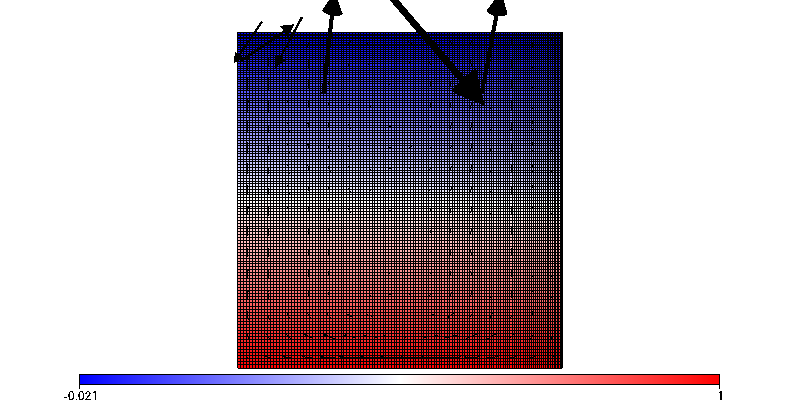

In [107]:
figtemp = glucifer.Figure( figsize=(800,400) )
figtemp.append( glucifer.objects.Surface(mesh, temperatureField, colours="blue white red") )
figtemp.append( glucifer.objects.Mesh(mesh) )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField, arrowHead=0.2, scaling=0.02))
figtemp.show()
#figtemp.save_database('test.gldb')



In [53]:
import matplotlib.pyplot as pyplot
%matplotlib inline

In [54]:
uni= np.genfromtxt(os.path.join("noRefine.txt"), skip_header=0)
rold= np.genfromtxt(os.path.join("oldRefine.txt"), skip_header=0)
rnew= np.genfromtxt(os.path.join("newRefine.txt"), skip_header=0)



In [55]:
colnames = ["Steps", "Time", "visc", "Nusselt_bottom", "Nusselt_top", "av_T", "vrms", "surf_rms", "surf_max", "grav", "etamax", "etamin"]

vrms


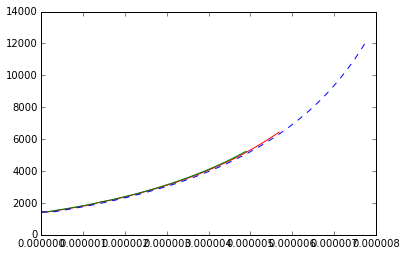

In [63]:
col = 6
print(colnames[col])

pyplot.plot(rold[:, 1], rold[:, col], c = 'r')
pyplot.plot(rnew[:, 1], rnew[:, col], c = 'g')
pyplot.plot(uni[:, 1], uni[:, col], c = 'b', linestyle = '--')
#pyplot.ylim((0, 0.6))

Save final fields - useful for continuing runs.